In [1]:
import pandas as pd 
#pandas is used to handle tables, Excel-like data (rows and columns).
#Think: pd.read_csv() reads the dataset like opening a spreadsheet.

import numpy as np 


#numpy is for numbers and math. Helps in calculations like mean, std, etc.
import matplotlib.pyplot as plt
import seaborn as sns 
#these are plotting libraries to visualize data (e.g., heatmaps, bar charts).
from sklearn.model_selection import train_test_split
#This function splits your data into two parts: training (to learn) and testing (to check if it learned well).
from sklearn.preprocessing import StandardScaler

# Standardizes your features so all numbers are on the same scale. This helps models like logistic regression.
from sklearn.linear_model import LogisticRegression 
#This imports the Logistic Regression model, used to predict yes/no outcomes (like churn or not).


In [59]:
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, roc_auc_score, roc_curve
#These are tools to measure model performance.
from sklearn.model_selection import GridSearchCV


In [60]:
import xgboost as xgb  # Main model - eXtreme Gradient Boosting
import warnings  # To hide unnecessary warnings
warnings.filterwarnings("ignore")  # Stop showing warning messages

In [61]:
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)  # Load the CSV from GitHub into a DataFrame


In [62]:



df = pd.read_csv("https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv")
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [63]:
if 'customerID' in df.columns:
    df.drop('customerID', axis=1, inplace=True)  # Remove ID column (not useful for ML)

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')  # Convert string to numbers; errors become NaN
df.dropna(inplace=True)  # Drop rows with missing values


In [64]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})  # Convert target variable to 1 (Yes), 0 (No)


In [65]:
cat_cols = df.select_dtypes(include='object').columns  # Get all text (categorical) columns
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)  # One-hot encode them (convert to 0/1), drop 1st to avoid dummy trap


In [66]:
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']  # Select numeric columns for scaling
scaler = StandardScaler()  # Create a scaler object
df[num_cols] = scaler.fit_transform(df[num_cols])  # Standardize: mean = 0, std = 1


In [67]:
#Split the Dataset
X = df.drop('Churn', axis=1)  # Features (all columns except the target)
y = df['Churn']  # Target column

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)  # Split data into training/testing, keeping class ratio same (stratify)


In [68]:
#Train XGBoost Model with GridSearchCV
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')  
# Create XGBoost classifier, disable label encoder warning, set eval metric to logloss (binary classification)


In [69]:
# Define a dictionary of hyperparameters to search
param_grid = {
    'n_estimators': [100, 200],  # Number of trees
    'max_depth': [3, 5, 7],  # Tree depth (complexity)
    'learning_rate': [0.01, 0.1, 0.2],  # How much to adjust with each tree
    'subsample': [0.8, 1]  # Percentage of data to use per tree
}


In [70]:
# Create GridSearchCV object to try different combinations
grid = GridSearchCV(
    xgb_clf, param_grid, cv=3, scoring='roc_auc', verbose=1, n_jobs=-1
)
grid.fit(X_train, y_train)  # Train with cross-validation and grid search


Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                   

In [71]:
best_model = grid.best_estimator_  # Save the best model after grid search
print("✅ Best Parameters:", grid.best_params_)  # Show best settings found


✅ Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


In [72]:
#Evaluate the Model
y_pred = best_model.predict(X_test)  # Predict churn on test set
y_prob = best_model.predict_proba(X_test)[:, 1]  # Get probability of class 1 (Yes)

print("🎯 Accuracy:", accuracy_score(y_test, y_pred))  # Correct predictions / total
print("\n📜 Classification Report:\n", classification_report(y_test, y_pred))  # Precision, recall, F1
print("\n📊 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))  # TP, TN, FP, FN
print("\n🔥 ROC-AUC Score:", roc_auc_score(y_test, y_prob))  # AUC = ability to rank positives > negatives


🎯 Accuracy: 0.7967306325515281

📜 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.87      1033
           1       0.64      0.53      0.58       374

    accuracy                           0.80      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.79      0.80      0.79      1407


📊 Confusion Matrix:
 [[922 111]
 [175 199]]

🔥 ROC-AUC Score: 0.8387244979836518


<Figure size 720x432 with 0 Axes>

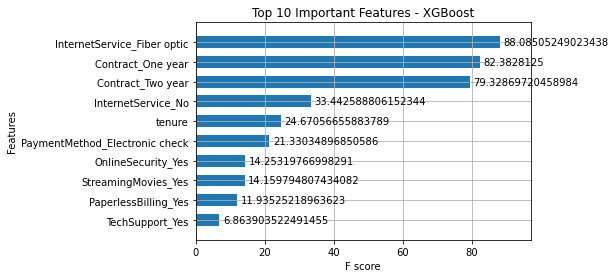

In [74]:
#Feature Importance 
plt.figure(figsize=(10, 6))  # Set plot size
xgb.plot_importance(best_model, max_num_features=10, importance_type='gain', height=0.6)  
# Plot top 10 most important features (gain = how much each feature helps reduce error)
plt.title("Top 10 Important Features - XGBoost")
plt.show()
